# Proactive Interference Branch


In [90]:
from glob import glob as glob
from itertools import product

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# cluster data
- model with LSTM perceptual layer

### load net

In [124]:
def load_net(seed,trep,switchmaps):
  net = PINet(
          stimdim=10,
          stsize=25,
          outdim=3,
          ninstructs=3+1,
          seed=seed
  )
  trep *= 100000
  fpath = 'model_data/PITask/'
  fpath += "LSTM_25-ntokens_3-seqlen_3-ntrials_2-switchmaps_%s-seed_%s-tr_%s-model.pt"%(switchmaps,seed,trep)
  # load
  net.load_state_dict(tr.load(fpath))
  return net


def load_netL(EM,trep,switch):
  netL = []
  for sd in range(20):
    try:
      net = load_net(sd,trep,switch)
      net.EMbool = EM
      netL.append(net)
    except:
      pass
  print('N =',len(netL),'loaded nets')
  return netL


def eval_net(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  fixed sequence length eval
  new embedding for every episode
  returns score
  """
  maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.randomize_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,switchmaps)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def eval_netL(netL,task,neps,ntrials,seqlen,switchmaps):
  """ returns acc `[sub,tsteps]`
  """
  nsubs = len(netL)
  tsteps = ntrials*seqlen + ntrials*3
  group_acc = np.ones([nsubs,tsteps]) 

  for sid,net in enumerate(netL):
    evsc = eval_net(net,task,neps,ntrials,seqlen,switchmaps)
    group_acc[sid] = evsc.mean(0)
  return group_acc
  


In [159]:
# init task
task = PurePM(
        ntokens=3,
        stimdim=10,
        seed=np.random.randint(999)
)

# list of networks
trep = 6
switch_train = 0
# with and without EM
netL_em0 = load_netL(0,trep,switch_train)
netL_em1 = load_netL(1,trep,switch_train)

N = 20 loaded nets
N = 20 loaded nets


In [162]:
neps = 500
ntrials = 5
seqlen = 5
switch_eval = 1

acc_em0 = eval_netL(netL_em0,task,neps,ntrials,seqlen,switch_eval)
acc_em1 = eval_netL(netL_em1,task,neps,ntrials,seqlen,switch_eval)

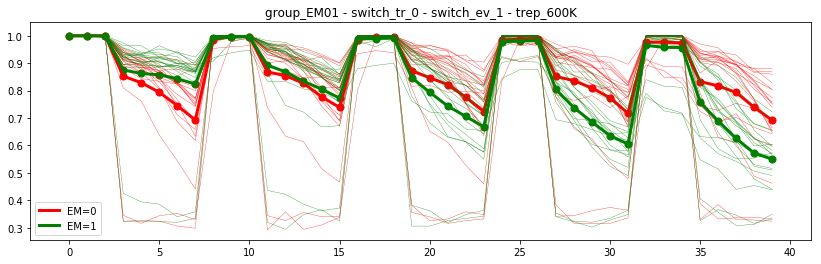

In [164]:
plt.figure(figsize=(14,4))
ax = plt.gca()
cL = ['r','g']
labL = ['EM=0','EM=1']

for gidx,acc in enumerate([acc_em0,acc_em1]):
  for sub_acc in acc:
    ax.plot(sub_acc,lw=.3,c=cL[gidx])
  ax.plot(acc.mean(0),c=cL[gidx],lw=3,label=labL[gidx])
  ax.scatter(range(acc.shape[1]),acc.mean(0),c=cL[gidx],s=50)
  
plt.legend()
title = "group_EM01-switch_tr_%i-switch_ev_%i-trep_%s00K"%(switch_train,switch_eval,trep)
plt.title(' - '.join(title.split('-')))
plt.savefig('figures/PIsweep_EM/'+title)

# debug EM
- find rand seed where first trial of lstm percept layer is at chance, and look at retrieval patters

In [418]:
ntokens = 2

sdim = 10
stsize = 25
outdim = ntokens
ninstructs = ntokens + 1
seed = np.random.randint(300)

task = PurePM(ntokens,sdim,seed=seed)
net = PINet(sdim,stsize,outdim,ninstructs,seed=seed)

In [469]:
-pairwise_distances([[1,0]],[[1,0],[0,1],[-10,0]],metric='cosine')

array([[-0., -1., -2.]])

In [481]:
task.randomize_emat()
c,x,y = task.gen_ep_data(3,2)
yhat = net(c,x)
x[:,0,1:3]


- tensor([1]) tensor(0.9143)

- tensor([0]) tensor(0.2787)

- tensor([2]) tensor(0.9143)
[-0.39 -0.13]

- tensor([2]) tensor(0.9143)
[-0.57 -0.24]

- tensor([0]) tensor(0.2787)

- tensor([1]) tensor(0.9143)

- tensor([2]) tensor(0.2787)
[-1.19 -0.98 -0.15 -0.13]

- tensor([2]) tensor(0.2787)
[-1.2  -1.12 -0.26 -0.22]

- tensor([0]) tensor(0.2787)

- tensor([1]) tensor(0.9143)

- tensor([2]) tensor(0.9143)
[-1.22 -1.01 -0.24 -0.1  -0.16 -0.02]

- tensor([2]) tensor(0.2787)
[-1.33 -1.22 -0.33 -0.25 -0.03 -0.06]


tensor([[0.6612, 0.2941],
        [0.0633, 0.7619],
        [0.6612, 0.2941],
        [0.6612, 0.2941],
        [0.0633, 0.7619],
        [0.6612, 0.2941],
        [0.0633, 0.7619],
        [0.0633, 0.7619],
        [0.0633, 0.7619],
        [0.6612, 0.2941],
        [0.6612, 0.2941],
        [0.0633, 0.7619]])

In [392]:
net.qksim

array([-0.27999997,  0.38      ,  0.97      ,  0.99      ], dtype=float32)

In [655]:
net

PINet(
  (embed_instruct): Embedding(4, 10)
  (i2inst): Linear(in_features=10, out_features=10, bias=True)
  (lstm_stim): LSTMCell(10, 10)
  (ff_stim): Linear(in_features=10, out_features=10, bias=True)
  (lstm_main): LSTMCell(20, 25)
  (cell2outhid): Linear(in_features=25, out_features=25, bias=True)
  (ff_hid2ulog): Linear(in_features=25, out_features=3, bias=True)
  (ff_em2cell): Linear(in_features=25, out_features=25, bias=True)
)

In [654]:
c,x,y = task.gen_ep_data(1,5)
yh = net(c,x)
print('\n--',maxsoftmax(yh).numpy().T)
yh.softmax(-1).detach().numpy().round(2)


- tensor([1]) tensor(0.7426)

- tensor([2]) tensor(0.4411)

- tensor([0]) tensor(0.0419)

- tensor([3]) tensor(0.7426)
EM: [-0.05 -0.04 -0.04] 1

- tensor([3]) tensor(0.4411)
EM: [-0.11 -0.01 -0.01] 1

- tensor([3]) tensor(0.0419)
EM: [-0.16 -0.05 -0.02] 2

- tensor([3]) tensor(0.0419)
EM: [-0.21 -0.09 -0.04] 2

- tensor([3]) tensor(0.4411)
EM: [-0.26 -0.11 -0.07] 2

-- [[1 2 0 2 2 2 2 2]]


array([[[0.  , 1.  , 0.  ]],

       [[0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ]],

       [[0.04, 0.15, 0.81]],

       [[0.04, 0.19, 0.77]],

       [[0.24, 0.22, 0.55]],

       [[0.29, 0.28, 0.43]],

       [[0.34, 0.29, 0.38]]], dtype=float32)

# train and eval

In [676]:
ntokens = 3

sdim = 10
stsize = 25
outdim = ntokens
ninstructs = ntokens + 1
seed = np.random.randint(999)
EMbool = 1

task = PurePM(ntokens,sdim,seed=seed) 
net = PINet(sdim,stsize,outdim,ninstructs,seed=seed,EMbool=EMbool)

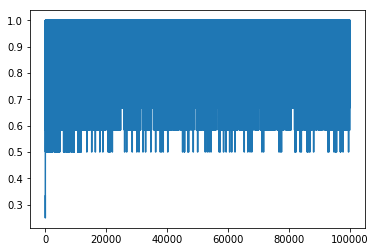

In [677]:
tracc = train_model(
          net,task,
          neps = 100000,
          ntrials = 2,
          seqlen = 3,
          switchmaps = 0,
          thresh = .95
)
plt.plot(tracc)

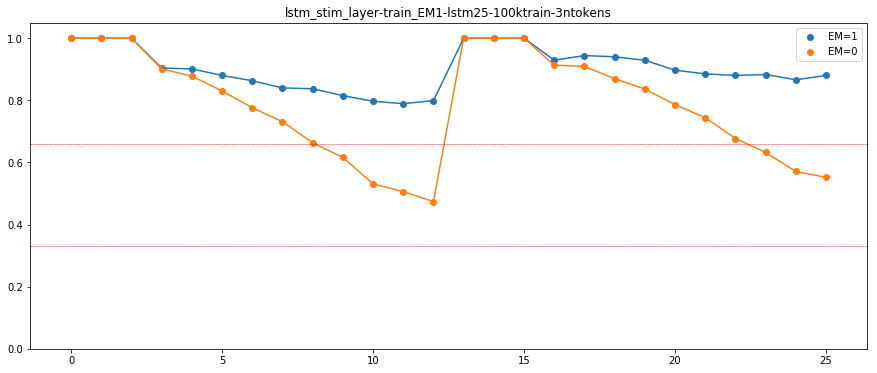

In [682]:
neps_ev = 1000
ntrials = 2
seqlen = 10
plt.figure(figsize=(15,6))

fname = 'lstm_stim_layer-train_EM%i-lstm25-100ktrain-%intokens'%(EMbool,ntokens)
plt.title(fname)

for t in [True,False]:
  # eval
  net.EMbool=t
  evsc = eval_model(net,task,neps_ev,ntrials,seqlen,switchmaps=0)
  # plot
  acc = evsc.mean(0)
  plt.plot(acc)
  plt.scatter(range(len(acc)),acc,label='EM=%i'%t)

for i in [.33,.66]:
  plt.axhline(i,c='r',ls='--',lw=.5)

plt.legend()
plt.ylim(0,1.05)
# plt.savefig('figures/em_test/'+fname)

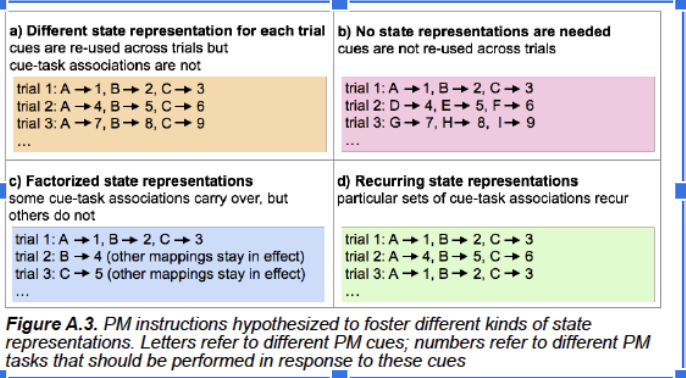

# todo
- run an experiment using the same procedure as the script used in the parasweep but with fixed embeddings. verify that LSTMs can indeed learn the task, and that the problem arises only in the case of trying to generalize to any vector. 

In [26]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

def train_model(net,task,neps,ntrials,seqlen,switchmaps,thresh=.99):
  """ 
  variable sequence length training
  closed loop randomizing of embedding
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  acc = -np.ones(neps)
  for ep in range(neps):
    # forward prop
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen=seqlen,switchmaps=switchmaps)
    yhat_ulog = net(tseq,xseq)
    # eval
    trial_acc = np.mean((maxsoftmax(yhat_ulog) == ytarget).numpy())
    acc[ep] = trial_acc
    # backprop
    for tstep in range(len(tseq)):
      optiop.zero_grad()
      loss = lossop(yhat_ulog[tstep],ytarget[tstep])
      loss.backward(retain_graph=True)
      optiop.step()
    if trial_acc>=thresh:
      task.randomize_emat()
  return acc

def eval_model2(net,task,neps,seqlen=4,ntrials=1):
  """ 
  fixed sequence length eval
  new embedding for every episode
  """
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.randomize_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def eval_model(net,task,neps,ntrials,seqlen,switchmaps):
  """ 
  fixed sequence length eval
  new embedding for every episode
  """
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
  for ep in range(neps):
    task.randomize_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen,switchmaps)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def mov_avg(arr,wind):
  X = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    X[t] = np.mean(arr[t:t+wind])
  return X

# load cluster data

In [4]:
sorted(glob('model_data/PITask/LSTM_*-ntokens_*-seqlen_*-ntrials_*-switchmaps_*-seed_*-evscore.npy'))

['model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_1-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_10-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_2-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_3-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_4-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_5-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_6-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_7-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_8-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_9-e

### plot eval data

In [2]:
def plot_evacc(fpathL):
  plt.figure(figsize=(10,4))
  for fpath in fpathL:
    subj_acc = np.load(fpath).mean(0)
    ax = plt.gca()
    ax.plot(subj_acc)
    ax.scatter(range(len(subj_acc)),subj_acc)
    ax.set_ylim(0,1.05)
    ax.axhline(1/ntokens,c='r',ls='--')
    ax.axvline(ntokens-.5,c='purple',ls='--')

  fname = 'stsize%i-ntokens%i-seqlen%i'%(stsize,ntokens,seqlen)
  plt.title(fname)
  plt.savefig('figures/PIsweep1/%s'%fname)
  plt.close('all')

# stL = [15,25,40]
# ntL = [2,3,4,5]
# sqL = [4,10,15]

stL = [40]
ntL = [2,3]
sqL = [2,4,6,8]

for stsize,ntokens,seqlen in product(stL,ntL,sqL):
  fpathL = glob('model_data/PITask/LSTM_%s-ntokens_%s-seqlen_%s-ntrials_2-switchmaps_0-seed_*-evscore.npy'%(
                stsize,ntokens,seqlen))
  plot_evacc(fpathL)
  


### plot train data

(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_9
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_4
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_2
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_8
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_5
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_3
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_6
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_0
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_7
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_10
(100000,)
LSTM_40-ntokens_2-seqlen_2-ntrials_2-switchmaps_0-seed_1


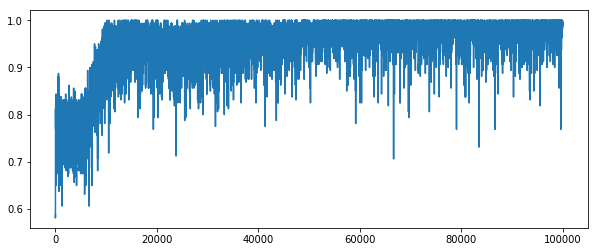

In [27]:
stsize = 40
ntokens = 2
seqlen= 2
fpathL = glob('model_data/PITask/LSTM_%s-ntokens_%s-seqlen_%s-ntrials_2-switchmaps_0-seed_*-tracc.npy'%(
                stsize,ntokens,seqlen))
fpathL

for fpath in fpathL:
  plt.close('all')
  plt.figure(figsize=(10,4))
  acc = np.load(fpath)
  print(acc.shape)
  try:
    plt.plot(mov_avg(acc,20))
    fname = fpath.split('/')[-1].split('-tracc')[0]
    print(fname)
    plt.savefig('figures/PIsweep1/'+'tracc-'+fname)
  except:
    pass

# explore params that learn

stsize40-ntokens2-seqlen4.png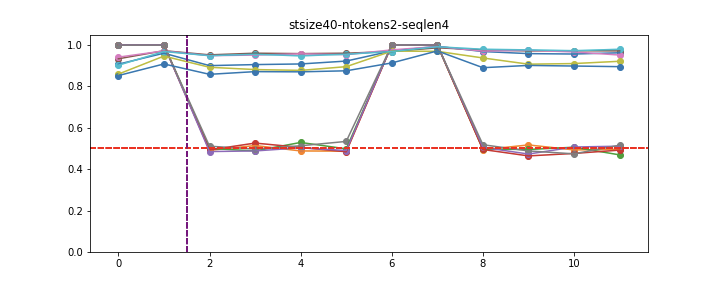

In [18]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

sdim = 10
ntokens = 2
seed = 2
stsize = 40
tr_seqlen = 2

net = PINet(
        stimdim=sdim,
        stsize=stsize,
        outdim=ntokens,
        ninstructs=ntokens+1,
        seed=seed
)
task = PurePM(
        ntokens=ntokens,
        stimdim=sdim,
        seed=seed
)
path = 'model_data/PITask/LSTM_%i-ntokens_%i-seqlen_%i-ntrials_2-switchmaps_0-seed_%i-model.pt'%(
          stsize,ntokens,tr_seqlen,seed)
net.load_state_dict(tr.load(path))


(0.6, 1)

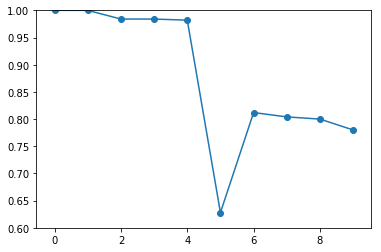

In [19]:
evsc = eval_model(net,task,neps=500,ntrials=2,seqlen=3,switchmaps=1)
M = evsc.mean(0)
plt.plot(M)
plt.scatter(range(len(M)),M)
plt.ylim(0.6,1)

# debug

# Cluster script